In [85]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plot
from IPython.display import clear_output
import math
import random
from collections import namedtuple
from itertools import count

# Prediction-Dependent Optimisation Routines

This notebook uses the Swansea Bay Tidal Lagoon project as a Case Study for all optimisation routines.

For all analysis, ocean measurements and predictions are taken from BODC (British Oceanographic Data Center).

All optimisations are energy-oriented.

# 0D Tidal Lagoon Model

Variable Lagoon Area Al

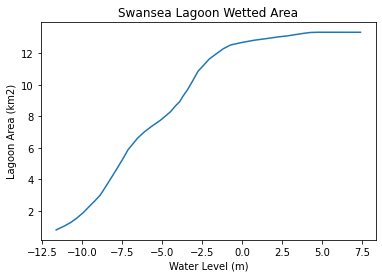

In [136]:
# import lagoon area as a function of bathymetry - Swansea Bay Tidal Lagoon model.
Al = np.genfromtxt('_wansea.csv', delimiter=',')

fig, ax1 = plt.subplots()

ax1.set_xlabel('Water Level (m)')
ax1.set_ylabel('Lagoon Area (km2)')
ax1.set_title('Swansea Lagoon Wetted Area')
ax1.plot(Al[:,0], Al[:,1])
ax1.tick_params(axis='y')

Functions for simulating turbine operation (power generation and idling modes) and sluice gates.

All models assume 1 min. time-step (Minscale = 60 used for data convertion x/s to x/min).

In [137]:
# Andritz Turbine Eq.
def PowerGen(g,rho,nt,Sp,Dt,To,CE,Ca, head, nTurb, MinScale, top):
  if (np.abs(head) >= 1 and top == "powerGen"): # Minimum head of 1m for Power Gen.
    n11 = Sp*Dt/np.sqrt(np.abs(head));
    if n11 <= 255: # Should there be a lower limit?
      Q11 = 0.017*n11 + 0.49;
    elif n11 > 255:
      Q11 = 4.75;
    Eff = (-0.0019*n11 + 1.2461)*CE; # Turbine Efficiency
    if Eff <=0:
      Eff = 0;
    elif Eff >= .95:
      Eff = .95;
    if (To == 1): # Flood Orientation
      if head < 0: # Ebb Gen
        Eff = 0.90*Eff;
    elif(To == 2): # Ebb Orientation
      if head > 0: # Flood Gen
        Eff = 0.90*Eff;
    Qt = nt*np.sign(head)*Q11*Dt**2*np.sqrt(np.abs(head)); # Andritz chart
    Pow = np.abs(rho*g*head*Qt)*Eff;
    if (Ca != 0) and (Pow > nt*Ca):
      POW = nt*Ca # Ca = turbine capacity (20MW for the Swansea Lagoon)
      QT = np.sign(head)*POW/(rho*g*np.abs(head)*Eff) # Dividing by Eff increases flow-rate above Ca (conservative)
    else:
      POW = Pow
      QT = Qt
    QTc = QT * MinScale;
    En = POW * MinScale * 10**-6; # Conversão para MJ
  else:
    QTc = 0;
    En = 0;
  return QTc, En

In [88]:
# Orifice Eq.
def idling(g,rho,head,At,nt,CDt,sop,MinScale):
  if (sop == "sluicing"):
    Qs = nt*np.sign(head)*CDt*At*np.sqrt(2*g*np.abs(head))
  else:
    Qs = 0
  return Qs* MinScale

In [89]:
# Orifice Eq.
def sluices(g,rho,head,As,CD,sop,MinScale):
  if (sop == "sluicing"):
    Qs = np.sign(head)*CD*As*np.sqrt(2*g*np.abs(head))
  else:
    Qs = 0
  return Qs* MinScale

Fixed Parameters Definition

In [90]:
# Delta time:
MinScale = 60; # (60s/m)
# Physical and Tidal Lagoon Coefficients
To = 2; # Turbine Orientation -> To = 2: Ebb Orientation (Penalty when generating energy in Flood Regime (ocean wl > lagoon wl))
g = 9.81; # Gravity acceleration (m/s2)
rho = 1024; # Seawater density (kg/m3)
nt = 16; # Number of turbines
f = 50; # Grid frequency (Hz)
Np = 95; # Number of generator poles in the turbine ?? (ref: Athanasius)
Dt = 7.35; # Bulb turbine diameter (m)
Ca = 20 * 10**6; # (All 16 units = 20MW)
CD = 1;
CDt = 1.36; # Turbine Discharge Coefficient when running in Idling mode
Sp = 2 * 60 * f / Np; # Turbine speed ?? (ref: Athanasius)
At = np.pi * Dt**2 / 4;
As = 800; # Value based on paper from Athanasius, where total sluice area = 800 m2 (80*10)
# Barrage Losses ( Aggidis - Operational optimization of a tidal barrage across the Mersaey Estuary)
Eff_ge = .97; # Generator Efficiency (Andre, 1976)
Eff_te = .995; # Transformer Efficiency (Libaux et al, 2011)
Eff_we = .95; # Water Friction (Baker and Leach, 2006)
Eff_gear_box_e = .972; # Gear Box/Drive train (Taylor, 2008)
Eff_turbine_avail = .95; # Turbine availlability in lifecycle (Baker and Leach, 2006)
CE = Eff_ge * Eff_te * Eff_we * Eff_gear_box_e * Eff_turbine_avail; # Turbine local efficiency losses - Calculated in Awake
# Momentum Ramp Hyperparameter
Zeta = 0.4

In [128]:
%run TidalLagoonFunctions.ipynb # Import Prediction-Dependent Optimization Routines

# Load & Preprocess BODC (prediction & measurements) files

### Choose data for operation and make resolution = 1 min

In [92]:
def GetDataBODC(ii):
   
    file = str(ii) + 'r.csv' # BODC 'r = real' measurement files
    my_data = genfromtxt(file)
    owl_real_load = my_data[:] ;
    owl_real_15min = owl_real_load # - np.mean(owl_real_load);
    time = np.linspace(0,(1/4)*(owl_real_15min.shape[0]-1),owl_real_15min.shape[0])
    
    fileb = str(ii) + 'p.csv' # BODC 'p = prediction' files
    my_datab = genfromtxt(fileb)
    owl_b_load = my_datab[:] ;
    owl_bp_15min = owl_b_load # - np.mean(owl_b_load);
    timeb = np.linspace(0,(1/4)*(owl_bp_15min.shape[0]-1),owl_bp_15min.shape[0])
    
    # Make BODC file resolution = 1 min (instead of 15 min)
    
    # BODC real data: 
    stop = 24*4*30 # Last point number to complete a month (deltaT =  15 min) 
    kk = 0; jj = 0;
    owl_real_min = []
    while kk < stop: 
        temp = (owl_real_15min[kk]*(15-jj)/15 + (jj/15)*owl_real_15min[kk+1])
        owl_real_min.append(temp)
        if (jj % 15 == 0 and jj != 0): # 15 minutes passed
            jj = 0;
            kk += 1
        jj += 1 
        
    # BODC prediction data: 
    stop = 24*4*30 # Last point number to complete a month (deltaT =  15 min) 
    kk = 0; jj = 0;
    owl_BODCp_min = []
    while kk < stop: 
        temp = (owl_bp_15min[kk]*(15-jj)/15 + (jj/15)*owl_bp_15min[kk+1])
        owl_BODCp_min.append(temp)
        if (jj % 15 == 0 and jj != 0): # 15 minutes passed
            jj = 0;
            kk += 1
        jj += 1 
    
    timeMin = np.linspace(0, len(owl_bp_15min)-1, len(owl_bp_15min)) # Time, by the minute
    
    return owl_real_min, owl_BODCp_min, timeMin, owl_real_15min, owl_bp_15min

Cut every half-tide for both JTides and BODC datasets. This process utilizes the ocean data where res = 15 min

In [93]:
def returStartEndHT(ocean15MinRes):
    # 1st time reading ocean data, first change in sign (ocean) = first cut
    # 2nd cut, and so forth, are found when the derivative (ocean[kk+1] + ocean[kk]) switches sign
    StartEndHT = []
    ii = 0
    delta = 0
    StartEndHT.append(ii)
    derivSignalI = np.sign(ocean15MinRes[2] - ocean15MinRes[1]); # Initial slope
    for owl in ocean15MinRes[0:-1]:
        if (ocean15MinRes[ii+1] != owl) and delta > 10: # Ignore small perturbations
            derivSignal = np.sign(ocean15MinRes[ii+1] - owl)
            if (derivSignal != derivSignalI):
                StartEndHT.append(ii)
                derivSignalI = derivSignal
                delta = 0
        ii += 1
        delta +=1 
    
    return StartEndHT

# Final ocean range to be considered in simulation starts at StartEndHT[0] and ends at StartEndHT[-1] -> Only half-tides considered

In [94]:
for Data in range(1,27):
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    StartEndHT = returStartEndHT(owl_pb_15)

    print(StartEndHT[-1]+1)

2860
2859
2881
2881
2858
2882
2860
2882
2859
2881
2861
2858
2861
2882
2858
2858
2859
2882
2881
2881
2882
2882
2861
2861
2859
2858


In [95]:
Data = 1
owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
StartEndHT = returStartEndHT(owl_pb_15)

print('StartEndHT: ', StartEndHT)
print('Number of half-tides: ', len(StartEndHT)-1)
print('len(owl_r_15)-1: ', len(owl_r_15))

StartEndHT:  [0, 25, 51, 77, 102, 128, 154, 179, 204, 229, 255, 279, 305, 329, 355, 379, 404, 429, 454, 478, 503, 528, 553, 577, 602, 627, 652, 676, 701, 725, 750, 775, 800, 824, 849, 873, 898, 923, 948, 972, 997, 1021, 1047, 1071, 1096, 1120, 1146, 1170, 1195, 1220, 1246, 1271, 1296, 1322, 1347, 1373, 1399, 1424, 1450, 1475, 1500, 1525, 1550, 1575, 1600, 1625, 1650, 1674, 1699, 1723, 1748, 1772, 1797, 1821, 1846, 1870, 1895, 1919, 1944, 1968, 1993, 2017, 2042, 2066, 2091, 2115, 2140, 2164, 2189, 2213, 2238, 2262, 2287, 2311, 2336, 2360, 2385, 2409, 2435, 2458, 2483, 2507, 2533, 2556, 2582, 2605, 2632, 2655, 2681, 2705, 2732, 2756, 2782, 2808, 2834, 2859]
Number of half-tides:  115
len(owl_r_15)-1:  2881


In [96]:
MaxDelta = 0
kk = 0
for wl in owl_r[0:-1]:
    MaxTemp = np.abs(owl_pb[kk] - owl_pb[kk+1]) 
    if MaxTemp > MaxDelta:
        MaxDelta = MaxTemp
    kk+=1
print(MaxDelta)

0.047000000000000014


# CH Routine

In [97]:
def CHgetEnergyFromData(oceanData): 
    resVec = [1, .5, .25, .125, .0625, .03125, 0.015625, 0.0078125] # Difference in cm between operational head tested
    iteration = 0
    MaxEnBS1 = 0
    HminBegin = 1
    HminEnd = 3
    HstartBegin = 1
    HstartEnd = 6
    
    Fl = 0; Fp = 0; Fqt = 0; Fqs = 0
    for res in resVec:
        # Brute Force optimization (Find best Hstart and Hmin for a whole month):
        if iteration != 0:

            HstartBegin = BestConfig[0] - res
            HstartEnd   = BestConfig[0] + res
            HminBegin   = BestConfig[1] - res
            HminEnd     = BestConfig[1] + res

        numberHmin = int(1 + (HminEnd - HminBegin)/res)
        numberHstart = int(1 + (HstartEnd - HstartBegin)/res)
        for Hmin in np.linspace(HminBegin, HminEnd, numberHmin):
            for Hstart in np.linspace(HstartBegin, HstartEnd, numberHstart):
                Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOP(Hstart, Hmin, oceanData)
                if (EnOut > MaxEnBS1):
                    MaxEnBS1 = EnOut
                    Fl = Lagoon; Fp = Power; Fqt = Qturbine; Fqs = Qsluice
                    BestConfig = [Hstart, Hmin]
                iteration += 1
                    
    return MaxEnBS1, BestConfig, Fl, Fp, Fqt, Fqs

Get Upper Bound estimate (perfect forecast scenario) for CH method

In [98]:
CHUpperBoundEn = []; CHUpperBoundLagoon = []; CHUpperBoundOcean = []; CHUpperBoundStrategy = []
CHUpperBoundQt = []; CHUpperBoundQs = []; CHUpperBoundPow = []
for Data in range(1,27): # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    MaxEn, BestHstartHmin, Lagoon, Power, Qturbine, Qsluice = CHgetEnergyFromData(owl_r)
    CHUpperBoundEn.append(MaxEn/(3.6*10**6)) # GWh
    CHUpperBoundLagoon.append(Lagoon)
    CHUpperBoundOcean.append(owl_r)
    CHUpperBoundQt.append(Qturbine)
    CHUpperBoundQs.append(Qsluice)
    CHUpperBoundPow.append(Power)
    CHUpperBoundStrategy.append(BestHstartHmin)

In [99]:
CHUpperBoundEn

[33.65276823519373,
 34.65823972259154,
 36.19425057718776,
 30.775510927613993,
 38.39717596840077,
 31.217311513342544,
 32.460295937680165,
 31.314708056396366,
 38.34414870935561,
 32.32342761286354,
 28.59579237921866,
 33.15062763464004,
 30.247652864232624,
 28.259444619091422,
 29.46613457066457,
 31.41821058145871,
 37.24332213312004,
 39.09637386997632,
 38.15810500769485,
 37.347781820720705,
 29.939191926498196,
 31.98341825223782,
 32.60070211937589,
 33.75954908612882,
 32.35696600684639,
 33.07091328349176]

Get Actual Bound (Real-Time) estimate when using a whole month of tidal prediction data

In [100]:
CHMonthPredEn = []; CHMonthPredLagoon = []; CHMonthPredOcean = []; CHMonthPredStrategy = []
CHMonthPredQt = []; CHMonthPredQs = []; CHMonthPredPow = []
for Data in range(1,27): # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    _, BestHstartHmin, _, _, _, _ = CHgetEnergyFromData(owl_pb)
    Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOP(BestHstartHmin[0], BestHstartHmin[1], owl_r)
    CHMonthPredEn.append(EnOut/(3.6*10**6)) # GWh
    CHMonthPredLagoon.append(Lagoon)
    CHMonthPredOcean.append(owl_r)
    CHMonthPredQt.append(Qturbine)
    CHMonthPredQs.append(Qsluice)
    CHMonthPredPow.append(Power)
    CHMonthPredStrategy.append(BestHstartHmin)

# CHV Routine

In [101]:
def CHVgetEnergyFromData(oceanData): 
    resVec = [1, .5, .25, .125, .0625, .03125, 0.015625, 0.0078125] # Difference in cm between operational head tested
    iteration = 0
    MaxEnB2 = 0
    HminBegin = 1
    HminEnd = 3
    HstartBegin = 1
    HstartEnd = 6
    HsStartBegin = 1
    HsStartEnd = 5
    
    Fl = 0; Fp = 0; Fqt = 0; Fqs = 0
    for res in resVec:
        # Brute Force optimization (Find best Hstart and Hmin for a whole month):
        if iteration != 0:

            HstartBegin    = BestConfig[0] - res
            HstartEnd     = BestConfig[0] + res
            HminBegin      = BestConfig[1] - res
            HminEnd       = BestConfig[1] + res
            HsStartBegin   = BestConfig[2] - res
            HsStartEnd    = BestConfig[2] + res

        numberHmin = int(1 + (HminEnd - HminBegin)/res)
        numberHstart = int(1 + (HstartEnd - HstartBegin)/res)
        numberHsStart = int(1 + (HsStartEnd - HsStartBegin)/res)
        
        for HtMin in np.linspace(HminBegin, HminEnd, numberHmin):
            for HtStart in np.linspace(HstartBegin, HstartEnd, numberHstart):
                for HsStart in np.linspace(HsStartBegin, HsStartEnd, numberHsStart):
                    Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOPB2(HtStart, HtMin, HsStart, oceanData)
                    if (EnOut > MaxEnB2):
                        MaxEnB2 = EnOut
                        Fl = Lagoon; Fp = Power; Fqt = Qturbine; Fqs = Qsluice
                        BestConfig = [HtStart, HtMin, HsStart]
                    iteration += 1
                    
    return MaxEnB2, BestConfig, Fl, Fp, Fqt, Fqs

Get Upper Bound estimate (perfect forecast scenario) for CHV method

In [102]:
CHVUpperBoundEn = []; CHVUpperBoundLagoon = []; CHVUpperBoundOcean = []; CHVUpperBoundStrategy = []
CHVUpperBoundQt = []; CHVUpperBoundQs = []; CHVUpperBoundPow = []
for Data in range(1,27): # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    MaxEn, BestHstartHmin, Lagoon, Power, Qturbine, Qsluice = CHVgetEnergyFromData(owl_r)
    CHVUpperBoundEn.append(MaxEn/(3.6*10**6)) # GWh
    CHVUpperBoundLagoon.append(Lagoon)
    CHVUpperBoundOcean.append(owl_r)
    CHVUpperBoundQt.append(Qturbine)
    CHVUpperBoundQs.append(Qsluice)
    CHVUpperBoundPow.append(Power)
    CHVUpperBoundStrategy.append(BestHstartHmin)

In [118]:
CHVUpperBoundEn

[34.13585825212925, 35.127167318152715]

Get Actual Bound (Real-Time) estimate when using a whole month of tidal prediction data

In [104]:
CHVMonthPredEn = []; CHVMonthPredLagoon = []; CHVMonthPredOcean = []; CHVMonthPredStrategy = []
CHVMonthPredQt = []; CHVMonthPredQs = []; CHVMonthPredPow = []
for Data in range(1,27): # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    _, BestHstartHminHSstart, _, _, _, _, = CHVgetEnergyFromData(owl_pb)
    Lagoon, Power, Qturbine, Qsluice, EnOut = TidalLagoonOPB2(BestHstartHminHSstart[0], BestHstartHminHSstart[1], BestHstartHminHSstart[2], owl_r)
    CHVMonthPredEn.append(EnOut/(3.6*10**6)) # GWh
    CHVMonthPredLagoon.append(Lagoon)
    CHVMonthPredOcean.append(owl_r)
    CHVMonthPredQt.append(Qturbine)
    CHVMonthPredQs.append(Qsluice)
    CHVMonthPredPow.append(Power)
    CHVMonthPredStrategy.append(BestHstartHminHSstart)

In [105]:
CHVMonthPredEn

[32.38642729603018, 35.00039059250477]

# EHT Routine

In [106]:
def EHTgetEnergyFromData(oceanData): # Ocean data with res = 15min

#     start = timer() # BEGIN TIMER 
    everyHTHstartHmin = [] # Collection of tuples for TRS control
    everyHTOcean = [] # Save every ocean half-tide data with res = 1 min
    everyHTtimeMin = [] # Save every timeMin for ocean half-tide data
    everyHTLagoon = [] # Save every lagoon half-tide data with res = 1 min
    
    everyHTQt = [] # Save every half-tide Qt data with res = 1 min
    everyHTQs = [] # Save every half-tide Qs data with res = 1 min
    everyHTPow = [] # Save every half-tide Pow data with res = 1 min
    nextQandEn = [0, 0, 0]
    kk = 0;
    MonthEnTraining = 0
    
    StartEndHT = returStartEndHT(oceanData)
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMin contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        # Insert oceanMinHT and timeMin data to optimization algorithim
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            prevQandEn = nextQandEn
        MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop, nextQandEn = ehtB3(timeMin, oceanMinHT, initialLagoonElev, top, prevQandEn)
        MonthEnTraining += MaxEn
        everyHTHstartHmin.append(BestConfig)
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
        everyHTLagoon.append(Lagoon) # Save every lagoon half-tide data with res = 1 min
        everyHTQt.append(Qturbine)
        everyHTQs.append(Qsluice)
        everyHTPow.append(Power)
    
    return MonthEnTraining, everyHTLagoon, everyHTtimeMin, everyHTOcean, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHmin

Apply BestConfig heads from EHT into ocean data:

In [107]:
def EHTapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, BestConfig):

    kk = 0
    ii = 0
    MonthEn = 0
#     nextQandEn = [0, 0, 0]
    everyHTPower = [];
    everyHTQturbine = [];
    everyHTQsluice = [];
    everyHTLagoon = [];
    for oceanMin in everyHTOcean:
        timeMin = everyHTtimeMin[ii]
        HtStart = BestConfig[ii][0]
        HtMin   = BestConfig[ii][1]
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            prevQandEn = nextQandEn;
            
        Lagoon, Power, Qturbine, Qsluice, EnSum, ntop, nextQandEn = TidalLagoonOPB3(HtStart, HtMin, timeMin, oceanMin, initialLagoonElev, top, prevQandEn)
        everyHTPower.append(Power);
        everyHTQturbine.append(Qturbine);
        everyHTQsluice.append(Qsluice);
        everyHTLagoon.append(Lagoon)
        MonthEn += EnSum
        ii+=1
    return MonthEn, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice

Get Upper Bound estimate (perfect forecast scenario) for EHT method

In [108]:
nextQandEn = [0, 0, 0]
EHTUpperBoundEn = []; EHTUpperBoundLagoon = []; EHTUpperBoundTime = []; EHTUpperBoundOcean = []; EHTUpperBoundStrategy = []
EHTUpperBoundQt = []; EHTUpperBoundQs = []; EHTUpperBoundPow = []
for Data in range(1,27): # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    UbTest, LagoonBODC, time_np, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHmin_np = EHTgetEnergyFromData(owl_r_15)
    EHTUpperBoundEn.append(UbTest/(3.6*10**6)) # GWh
    EHTUpperBoundLagoon.append(LagoonBODC)
    EHTUpperBoundTime.append(time_np)
    EHTUpperBoundOcean.append(OceanBODC)
    EHTUpperBoundQt.append(everyHTQt)
    EHTUpperBoundQs.append(everyHTQs)
    EHTUpperBoundPow.append(everyHTPow)
    EHTUpperBoundStrategy.append(everyHTHstartHmin_np)

In [109]:
EHTUpperBoundEn

[43.72645119955317,
 43.358548142608505,
 44.40397680574694,
 41.67012408469018,
 43.95162766637957,
 42.81759684193128,
 43.02640240175089,
 40.76809491846881,
 41.66587074399614,
 42.44383128675747,
 38.583001137908674,
 38.74437140187294,
 42.14025467946402,
 41.29008797015722,
 40.875815920429964,
 41.64727678426563,
 41.83308659289848,
 44.50419763822193,
 44.910925125321185,
 43.84789928790343,
 41.06762847225243,
 41.94779051339762,
 43.61326690660448,
 43.24293648163641,
 42.4878340455037,
 41.60640024799092]

Get Actual Bound (Real-Time) estimate when using a whole month of tidal prediction data

In [110]:
# Fixed Hstart with conditioning
nextQandEn = [0, 0, 0]
EHTMonthPredEn = []; EHTMonthPredLagoon = []; EHTMonthPredTime = []; EHTMonthPredOcean = []; EHTMonthPredStrategy = []
EHTMonthPredQt = []; EHTMonthPredQs = []; EHTMonthPredPow = []
for Data in range(1,27): # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    TrainEnergy, _, _, _, _, _, _, everyHTHstartHmin = EHTgetEnergyFromData(owl_pb_15) # Get strategy from BODC prediction
    
    StartEndHT = returStartEndHT(owl_pb_15) # Get half-tides estimate from BODC data

    oceanData = owl_r_15
    everyHTtimeMin = []; everyHTOcean = []
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMinHT contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
    EHTSwansea_np, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice = EHTapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, everyHTHstartHmin)
    EHTMonthPredEn.append(EHTSwansea_np/(3.6*10**6)) # GWh
    EHTMonthPredLagoon.append(everyHTLagoon)
    EHTMonthPredTime.append(timeMin)
    EHTMonthPredOcean.append(everyHTOcean)
    EHTMonthPredQt.append(everyHTQturbine)
    EHTMonthPredQs.append(everyHTQsluice)
    EHTMonthPredPow.append(everyHTPower)
    EHTMonthPredStrategy.append(everyHTHstartHmin)

In [111]:
EHTMonthPredEn

[43.40852343447322,
 43.304541339892225,
 44.33151205691854,
 41.63561674605981,
 43.84530773338814,
 42.78852281301189,
 42.87688154453707,
 40.661694060768404,
 41.65324878793811,
 15.766101041798665,
 38.20189670288811,
 38.74802868575414,
 42.13608789066715,
 41.32641540465417,
 40.851762106774366,
 41.49530086598373,
 41.78241291258481,
 44.312728326592016,
 44.87185159043516,
 43.81091204842097,
 41.04747820748377,
 41.95831075277426,
 43.55410282018291,
 43.13728239758904,
 42.38508574573493,
 41.65981701137445]

# EHTV Routine

In [112]:
def EHTVgetEnergyFromData(oceanData): # Ocean data with res = 15min

#     start = timer() # BEGIN TIMER 
    everyHTHstartHminHsStart = [] # Collection of triples for TRS control
    everyHTOcean = [] # Save every ocean half-tide data with res = 1 min
    everyHTtimeMin = [] # Save every timeMin for ocean half-tide data
    everyHTLagoon = [] # Save every lagoon half-tide data with res = 1 min
    
    everyHTQt = [] # Save every half-tide Qt data with res = 1 min
    everyHTQs = [] # Save every half-tide Qs data with res = 1 min
    everyHTPow = [] # Save every half-tide Pow data with res = 1 min
    nextQandEn = [0, 0, 0]
    kk = 0;
    MonthEnTraining = 0
    
    StartEndHT = returStartEndHT(oceanData)
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMin contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        # Insert oceanMinHT and timeMin data to optimization algorithim
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            sop = nsop # Sequential sluice operation
            prevQandEn = nextQandEn
        MaxEn, Lagoon, BestConfig, Power, Qturbine, Qsluice, ntop, nsop, nextQandEn = ehtB4(timeMin, oceanMinHT, initialLagoonElev, top, sop, prevQandEn)
        MonthEnTraining += MaxEn
        everyHTHstartHminHsStart.append(BestConfig)
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
        everyHTLagoon.append(Lagoon) # Save every lagoon half-tide data with res = 1 min
        everyHTQt.append(Qturbine)
        everyHTQs.append(Qsluice)
        everyHTPow.append(Power)
    
    return MonthEnTraining, everyHTLagoon, everyHTtimeMin, everyHTOcean, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart

Apply BestConfig heads from EHTV into ocean data:

In [113]:
def EHTVapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, BestConfig):

    kk = 0
    ii = 0
    MonthEn = 0
#     nextQandEn = [0, 0, 0]
    everyHTPower = [];
    everyHTQturbine = [];
    everyHTQsluice = [];
    everyHTLagoon = [];
    for oceanMin in everyHTOcean:
        timeMin = everyHTtimeMin[ii]
        HtStart = BestConfig[ii][0]
        HtMin   = BestConfig[ii][1]
        HsStart   = BestConfig[ii][2]
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            sop = nsop # Sequential sluice operation
            prevQandEn = nextQandEn;
            
        Lagoon, Power, Qturbine, Qsluice, EnSum, ntop, nsop, nextQandEn = TidalLagoonOPB4_New(HtStart, HtMin, HsStart, timeMin, oceanMin, initialLagoonElev, top, sop, prevQandEn)
        everyHTPower.append(Power);
        everyHTQturbine.append(Qturbine);
        everyHTQsluice.append(Qsluice);
        everyHTLagoon.append(Lagoon)
        MonthEn += EnSum
        ii+=1
    return MonthEn, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice

Get Upper Bound estimate (perfect forecast scenario) for EHTV method

In [114]:
nextQandEn = [0, 0, 0]
EHTVUpperBoundEn = []; EHTVUpperBoundLagoon = []; EHTVUpperBoundTime = []; EHTVUpperBoundOcean = []; EHTVUpperBoundStrategy = []
EHTVUpperBoundQt = []; EHTVUpperBoundQs = []; EHTVUpperBoundPow = []
for Data in range(1,27):
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    BODCMonthEn, LagoonBODC, time, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart = EHTVgetEnergyFromData(owl_r_15)
    EHTVUpperBoundEn.append(BODCMonthEn/(3.6*10**6)) # GWh
    EHTVUpperBoundLagoon.append(LagoonBODC)
    EHTVUpperBoundTime.append(time)
    EHTVUpperBoundOcean.append(OceanBODC)
    EHTVUpperBoundQt.append(everyHTQt)
    EHTVUpperBoundQs.append(everyHTQs)
    EHTVUpperBoundPow.append(everyHTPow)
    EHTVUpperBoundStrategy.append(everyHTHstartHminHsStart)

In [115]:
EHTVUpperBoundEn

[44.69732734959117]

Get Actual Bound (Real-Time) estimate when using a whole month of tidal prediction data

In [116]:
# Fixed Hstart with conditioning
nextQandEn = [0, 0, 0]

EHTVMonthPredEn = []; EHTVMonthPredLagoon = []; EHTVMonthPredTime = []; EHTVMonthPredOcean = []; EHTVMonthPredStrategy = []
EHTVMonthPredQt = []; EHTVMonthPredQs = []; EHTVMonthPredPow = []
for Data in range(1,2):
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    TrainEnergy, _, _, _, _, _, _, everyHTHstartHminHsStart_np = EHTVgetEnergyFromData(owl_pb_15) # Get strategy from JTides prediction
    
    StartEndHT = returStartEndHT(owl_pb_15) # Get half-tides estimate from JTides data

    oceanData = owl_r_15
    everyHTtimeMin = []; everyHTOcean = []
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMinHT contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
    EHTVSwansea_np, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice = EHTVapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, everyHTHstartHminHsStart_np)
    EHTVMonthPredEn.append(EHTVSwansea_np/(3.6*10**6)) # GWh
    EHTVMonthPredLagoon.append(everyHTLagoon)
    EHTVMonthPredTime.append(timeMin)
    EHTVMonthPredOcean.append(everyHTOcean)
    EHTVMonthPredQt.append(everyHTQturbine)
    EHTVMonthPredQs.append(everyHTQsluice)
    EHTVMonthPredPow.append(everyHTPower)
    EHTVMonthPredStrategy.append(everyHTHstartHminHsStart_np)

In [117]:
EHTVMonthPredEn

[44.22641706058734]

# EHN Routine

In [129]:
def EHNgetEnergyFromData(oceanData): # Ocean data with res = 15min

#     start = timer() # BEGIN TIMER 
    everyPTHstartHminHsStart = [] # Collection of "pair" triples for TRS control
    everyHTOcean = [] # Save every ocean half-tide data with res = 1 min
    everyHTtimeMin = [] # Save every timeMin for ocean half-tide data
    everyHTLagoon = [] # Save every lagoon half-tide data with res = 1 min
    
    everyHTQt = [] # Save every half-tide Qt data with res = 1 min
    everyHTQs = [] # Save every half-tide Qs data with res = 1 min
    everyHTPow = [] # Save every half-tide Pow data with res = 1 min
    nextQandEn = [0, 0, 0]
    kk = 0;
    MonthEnTraining = 0
    
    StartEndHT = returStartEndHT(oceanData)
    for first, second, third in zip(StartEndHT, StartEndHT[1:], StartEndHT[2:]):
        jj = 0;
        oceanMinHT1 = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT1.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        jj = 0;
        oceanMinHT2 = [] 
        while second < third: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[second]*(15-jj)/15 + (jj/15)*oceanData[second+1])
            oceanMinHT2.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                second += 1
            jj += 1 
        # oceanMin contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin1 = np.linspace(0, len(oceanMinHT1)-1, len(oceanMinHT1)) # Time, by the minute 1st HT
        timeMin2 = np.linspace(0, len(oceanMinHT2)-1, len(oceanMinHT2)) # Time, by the minute 2nd HT
        # Insert oceanMinHT and timeMin data to optimization algorithim
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon1[-1]
            top = ntop1 # Sequential turbine operation
            prevQandEn = nextQandEn1
        MaxEn, Lagoon1, BestConfig, Power, Qturbine, Qsluice, ntop1, nextQandEn1 = etB3(timeMin1, oceanMinHT1, timeMin2, oceanMinHT2, initialLagoonElev, top, prevQandEn)
        MonthEnTraining += MaxEn
        time_temp = timeMin1; ocean_temp = oceanMinHT1;
        if (third == StartEndHT[-1]): # Means the last tide (not accounted by etB3)
            MaxEn, Lagoon1, BestConfig, Power, Qturbine, Qsluice, ntop, nextQandEn2 = ehtB3(timeMin2, oceanMinHT2, Lagoon1[-1], ntop1, nextQandEn1)
            MonthEnTraining += MaxEn
            time_temp = timeMin2; ocean_temp = oceanMinHT2;
        everyPTHstartHminHsStart.append(BestConfig)
        everyHTOcean.append(ocean_temp) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(time_temp) # Save every timeMin for ocean half-tide data
        everyHTLagoon.append(Lagoon) # Save every lagoon half-tide data with res = 1 min
        everyHTQt.append(Qturbine)
        everyHTQs.append(Qsluice)
        everyHTPow.append(Power)
    
    return MonthEnTraining, everyHTLagoon, everyHTtimeMin, everyHTOcean, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart

Get Upper Bound estimate (perfect forecast scenario) for EHN method

In [ ]:
nextQandEn = [0, 0, 0]
EHNUpperBoundEn = []; EHNUpperBoundLagoon = []; EHNUpperBoundTime = []; EHNUpperBoundOcean = []; EHNUpperBoundStrategy = []
EHNUpperBoundQt = []; EHNUpperBoundQs = []; EHNUpperBoundPow = []
for Data in range(1,27):
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    BODCMonthEn, LagoonBODC, time, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart = EHNgetEnergyFromData(owl_r_15)
    EHNUpperBoundEn.append(BODCMonthEn/(3.6*10**6)) # GWh
    EHNUpperBoundLagoon.append(LagoonBODC)
    EHNUpperBoundTime.append(time)
    EHNUpperBoundOcean.append(OceanBODC)
    EHNUpperBoundQt.append(everyHTQt)
    EHNUpperBoundQs.append(everyHTQs)
    EHNUpperBoundPow.append(everyHTPow)
    EHNUpperBoundStrategy.append(everyHTHstartHminHsStart)

In [130]:
owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(1)
BODCMonthEn, LagoonBODC, time, OceanBODC, everyHTQt, everyHTQs, everyHTPow, everyHTHstartHminHsStart = EHNgetEnergyFromData(owl_r_15)

In [132]:
BODCMonthEn/(3.6*10**6)

44.04746036088523

Get Actual Bound (Real-Time) estimate when using a whole month of tidal prediction data

In [133]:
def EHNapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, BestConfig):

    kk = 0
    ii = 0
    MonthEn = 0
    everyHTPower = [];
    everyHTQturbine = [];
    everyHTQsluice = [];
    everyHTLagoon = [];
    for oceanMin in everyHTOcean:
        timeMin = everyHTtimeMin[ii]
        HtStart = BestConfig[ii][0]
        HtMin   = BestConfig[ii][1]
        if kk == 0:
            prevQandEn = [0, 0, 0]
            initialLagoonElev = 0 # Initial Lagoon water level for optimization
            top = "powerGen" # Starting turbine operation
            sop = "holding" # Starting sluice operation
            kk = 1
        else: 
            initialLagoonElev = Lagoon[-1]
            top = ntop # Sequential turbine operation
            prevQandEn = nextQandEn;
            
        Lagoon, Power, Qturbine, Qsluice, EnSum, ntop, nextQandEn = TidalLagoonOPB3(HtStart, HtMin, timeMin, oceanMin, initialLagoonElev, top, prevQandEn)
        everyHTPower.append(Power);
        everyHTQturbine.append(Qturbine);
        everyHTQsluice.append(Qsluice);
        everyHTLagoon.append(Lagoon)
        MonthEn += EnSum
        ii+=1
    return MonthEn, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice

In [134]:
# Fixed Hstart with conditioning
nextQandEn = [0, 0, 0]
EHNMonthPredEn = []; EHNMonthPredLagoon = []; EHNMonthPredTime = []; EHNMonthPredOcean = []; EHNMonthPredStrategy = []
EHNMonthPredQt = []; EHNMonthPredQs = []; EHNMonthPredPow = []
for Data in range(1,3): # Get results for 26 months (pre-processed)
    owl_r, owl_pb, timeMin, owl_r_15, owl_pb_15 = GetDataBODC(Data)
    TrainEnergy, _, _, _, _, _, _, everyHTHstartHmin = EHNgetEnergyFromData(owl_pb_15) # Get strategy from BODC prediction
    
    StartEndHT = returStartEndHT(owl_pb_15) # Get half-tides estimate from BODC data

    oceanData = owl_r_15
    everyHTtimeMin = []; everyHTOcean = []
    for first, second in zip(StartEndHT, StartEndHT[1:]):
        jj = 0;
        oceanMinHT = [] 
        while first < second: # deltaT = 15min for owlCut, HT indexed by StartEndHT 
            temp = (oceanData[first]*(15-jj)/15 + (jj/15)*oceanData[first+1])
            oceanMinHT.append(temp)
            if (jj % 15 == 0 and jj != 0): # 15 minutes passed
                jj = 0;
                first += 1
            jj += 1 
        # oceanMinHT contains the ocean level varying in min for ~30 consecutive days (complete half tides considered)
        timeMin = np.linspace(0, len(oceanMinHT)-1, len(oceanMinHT)) # Time, by the minute
        everyHTOcean.append(oceanMinHT) # Save every ocean half-tide data with res = 1 min
        everyHTtimeMin.append(timeMin) # Save every timeMin for ocean half-tide data
    EHNSwansea_np, everyHTLagoon, everyHTPower, everyHTQturbine, everyHTQsluice = EHNapplyBestConfigToBODC(everyHTtimeMin, everyHTOcean, everyHTHstartHmin)
    EHNMonthPredEn.append(EHTSwansea_np/(3.6*10**6)) # GWh
    EHNMonthPredLagoon.append(everyHTLagoon)
    EHNMonthPredTime.append(timeMin)
    EHNMonthPredOcean.append(everyHTOcean)
    EHNMonthPredQt.append(everyHTQturbine)
    EHNMonthPredQs.append(everyHTQsluice)
    EHNMonthPredPow.append(everyHTPower)
    EHNMonthPredStrategy.append(everyHTHstartHmin)

In [135]:
EHNMonthPredEn

[41.65981701137445, 41.65981701137445]

In [ ]:
las = 35
les = 18
lax = 30

fig, ax = plt.subplots(figsize=[12,8])
# ax.plot(UpperBoundEn, 'x', color = 'blue', label = 'UpperBound (pred = meas)')
ax.plot(UbOcean, 'x', color = 'black', label = ' UpperBound (Ocean Engineering)')
# ax.plot(en_DRL, 'v', color = 'orange', label = ' DRL Agent')
en_DRL
ax.plot(LowerBoundEnN, 'x', color = 'green', label = 'Hstart Corrected Actual Bound')
# ax.plot(LowerBoundEn, 'x', color = 'red', label = 'Uncorrected Actual Bound')
# ax.plot(NewLb, 'x', color = 'red', label = ' New LowerBound (pred = meas)')

# ax.plot(Lb_c, 'v', color = 'green', label = 'LowerBound with Hstart*.95')
ax.plot(en_DRL, 'v', color = 'red', label = 'DRL Operation')
plt.xlabel('Sample Month', fontsize = las)
plt.ylabel('EHTV Energy (GWh) \n No Pump', fontsize = las)
plt.ylim(38, 53)
plt.yticks(fontsize=lax)
plt.xticks(fontsize=lax)
# ax.locator_params(axis='y', nbins=10)

# Set number of ticks for x-axis

# Set ticks labels for x-axis
# ax.set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=lax)

# plt.xaxis.get_major_ticks()
plt.legend(fontsize = les, facecolor='white', framealpha=1)
plt.show()